In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [2]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [3]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [4]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [5]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [6]:
ResultsDir = "/groups/gerlich/labinfo/2023_Batty_et_al/fig_by_fig_description/appendix_figures/appendix_figures_s1/panel_f/output/"

In [7]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [8]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [9]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#for the Halo TMR background fluorescence, WT cells were stained with Halo-TMR at the same time as SMC4. The Halo TMR fluorescence in the nuclei 
# of WT cells was then measured to correct for background >>> 6 cells from 3 images
#2108 minus auxin - Hoechst, 0.192, 0.120, 0.107 >>> 0.140
#2108 minus auxin, Scc1 - 3.162, 2.573, 2.537 >>> 2.76
#mean nuclear Halo fluorescence is 5.87 in wt cells
#2108 minus auxin - Wapl, 5.392, 4.844, 4.774 >>> 5.00



In [12]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):
    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_scc1 = pd.DataFrame()
    all_smc4 = pd.DataFrame()
    all_wapl = pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[:,:, 0]
        scc1 = data[:,:, 1]
        smc4 = data[:,:, 2]
        wapl = data[:,:, 3]
        #display_slice(wapl_ha)
        
        
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        
        #mask = hoechst > thresh
        binary_mask = morphology.binary_closing(blurred > thresh, disk(6)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 20000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_scc1 = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_scc1 = pd.DataFrame(regionprops_table(labels, scc1, 
             properties=properties_scc1))
        output_scc1 = output_scc1.rename(columns={"mean_intensity":"mean_scc1"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_scc1["total_nuclear_scc1"] = output_hoechst["nuclear_area_microns"] * output_scc1["mean_scc1"]
        
        #extract info for second channel, area is the same as for the first channel
        properties_smc4 = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_smc4 = pd.DataFrame(regionprops_table(labels, smc4, 
             properties=properties_smc4))
        output_smc4 = output_smc4.rename(columns={"mean_intensity":"mean_smc4"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_smc4["total_nuclear_smc4"] = output_hoechst["nuclear_area_microns"] * output_smc4["mean_smc4"]
        
        
        properties_wapl = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_wapl = pd.DataFrame(regionprops_table(labels, wapl, 
             properties=properties_wapl))
        output_wapl = output_wapl.rename(columns={"mean_intensity":"mean_wapl"})
        #output_wapl = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_wapl["total_nuclear_wapl"] = output_hoechst["nuclear_area_microns"] * output_wapl["mean_wapl"]
                

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_scc1 = pd.DataFrame(regionprops_table(labels, scc1, extra_properties=[image_stdev]))
        
        output_scc1["std_scc1"] = props_scc1["image_stdev"]
        
        props_smc4 = pd.DataFrame(regionprops_table(labels, smc4, extra_properties=[image_stdev]))
        
        output_smc4["std_smc4"] = props_smc4["image_stdev"]
        
        props_wapl = pd.DataFrame(regionprops_table(labels, wapl, extra_properties=[image_stdev]))
        
        output_wapl["std_wapl"] = props_wapl["image_stdev"]
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_scc1 = all_scc1.append(output_scc1)
        all_smc4 = all_smc4.append(output_smc4)
        all_wapl = all_wapl.append(output_wapl)
       
        #print(output_hoechst)
        #print(output_scc1)
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_scc1, all_smc4, all_wapl], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["nuclear_area_microns", "mean_hoechst", "mean_scc1", "mean_smc4", "mean_wapl", "total_hoechst", "total_nuclear_scc1", "total_nuclear_smc4", "total_nuclear_wapl", "std_hoechst", "std_scc1"]]
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    #exclude outliers with very high WAPL fluorescence to not distort range of values
    final_df = final_df.loc[(final_df.mean_wapl < 55)]
    #set threshold to exclude mitotic cells where SMC4 will enrich on mitotic chromosomes
    threshold = (final_df.mean_smc4.mean())*2
    final_df = final_df.loc[final_df.mean_smc4 < threshold]
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_smc4"] = final_df["std_scc1"]/final_df["mean_scc1"]
    final_df["condition"] = "2108_plus_aux_plus_dtag"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "2108_plus_aux_plus_dtag.csv"), index = False)
    return final_df


/tmp/ipykernel_57954/685911536.py:36: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(


2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos41-44 #1.tif


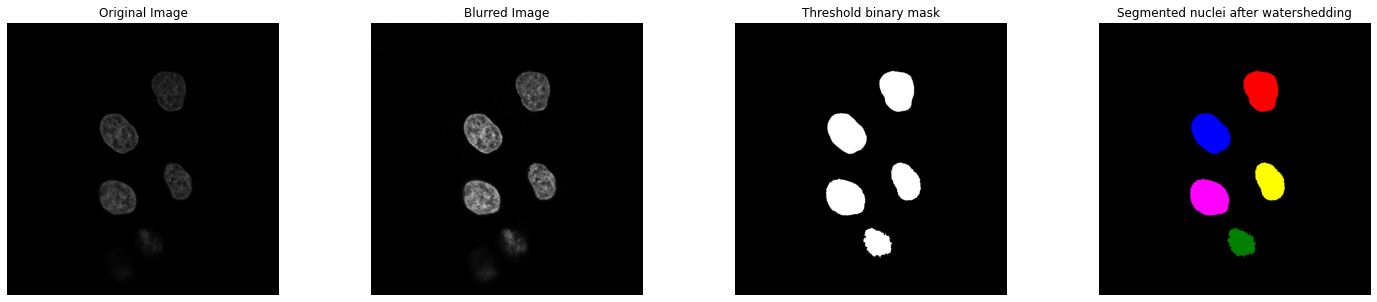

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-16 #3.tif


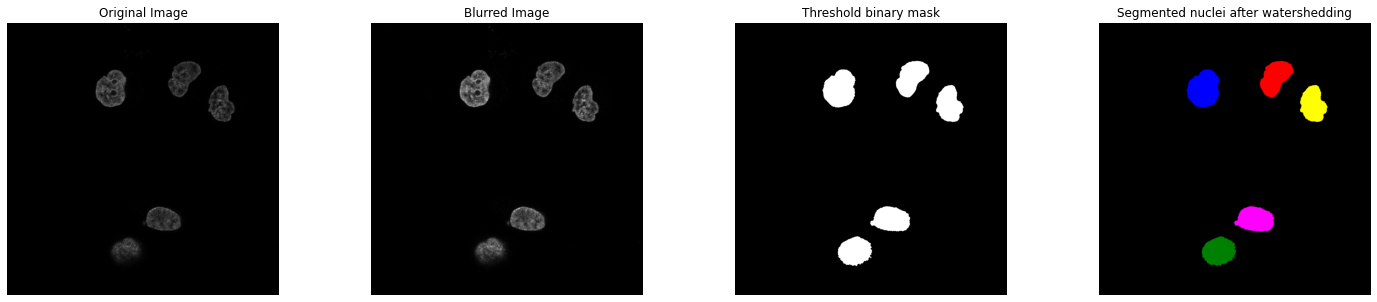

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-16 #2.tif


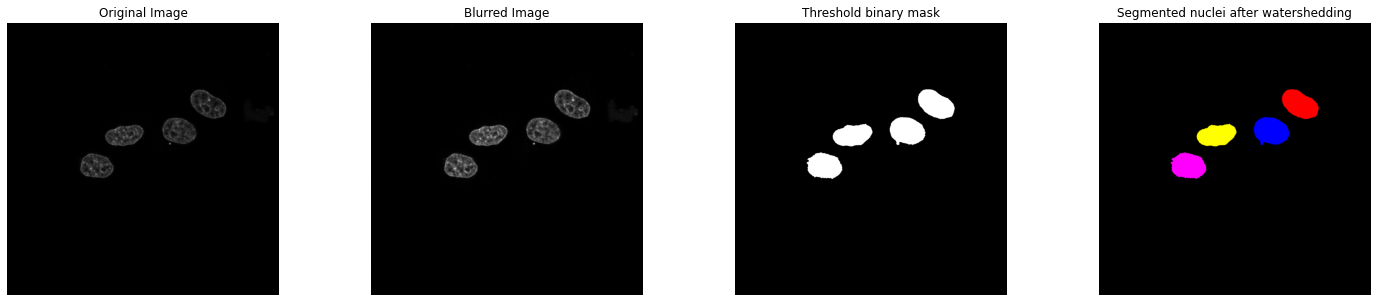

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-16 #1.tif


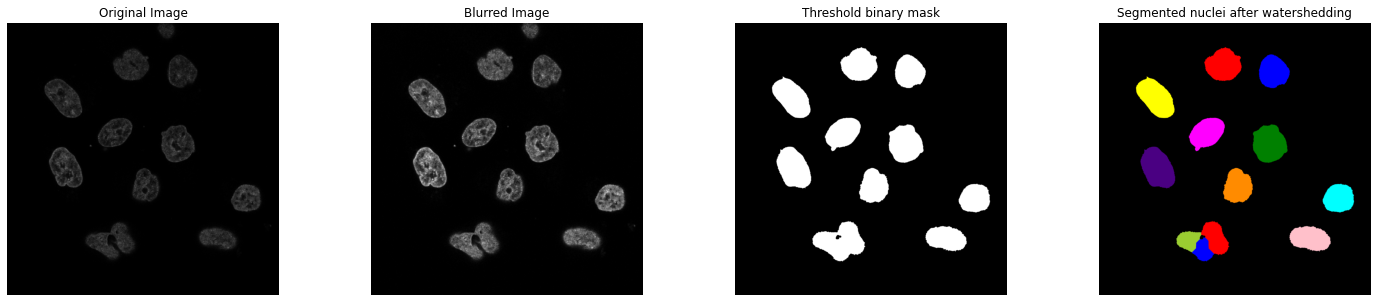

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #8.tif


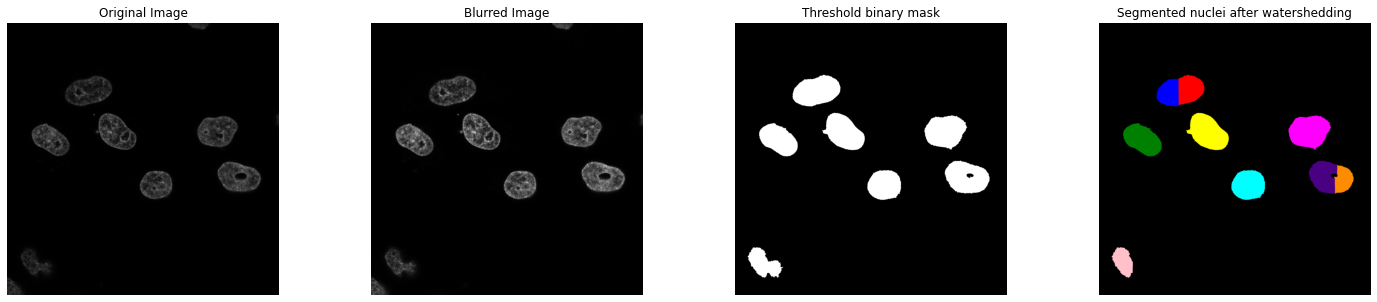

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #09.tif


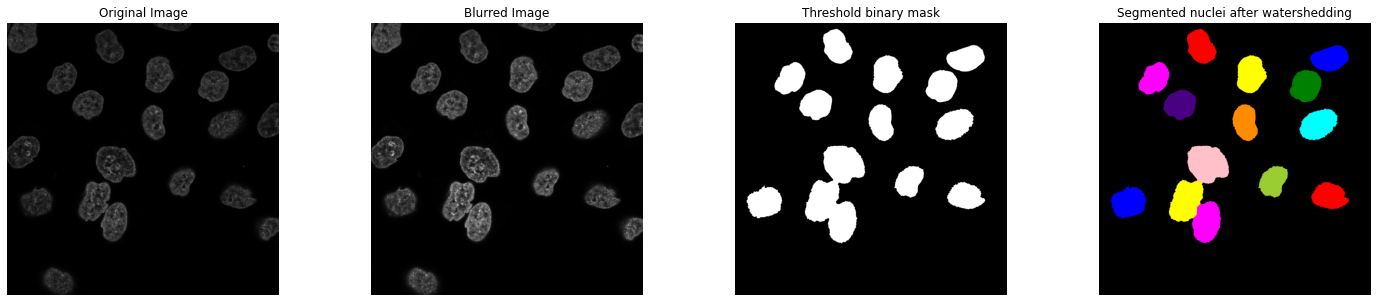

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #6.tif


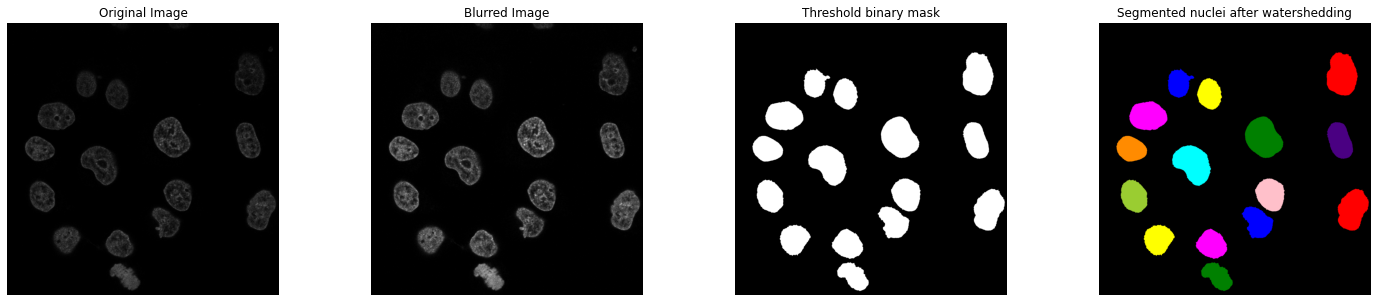

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #5.tif


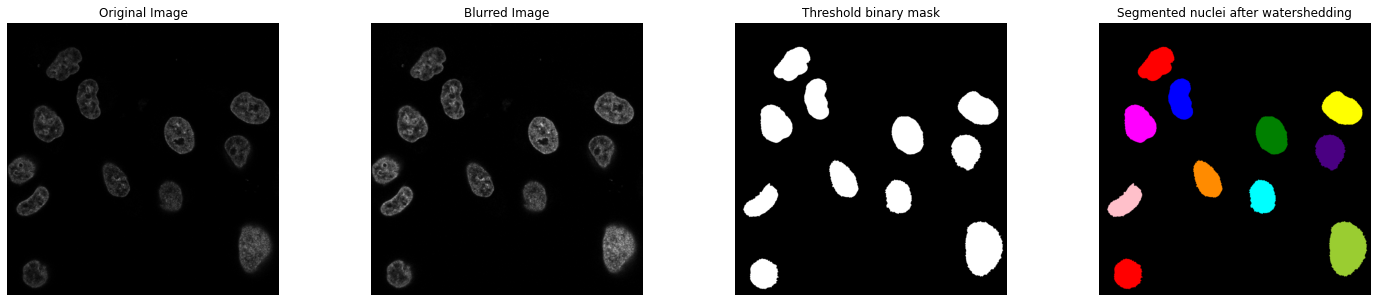

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #7.tif


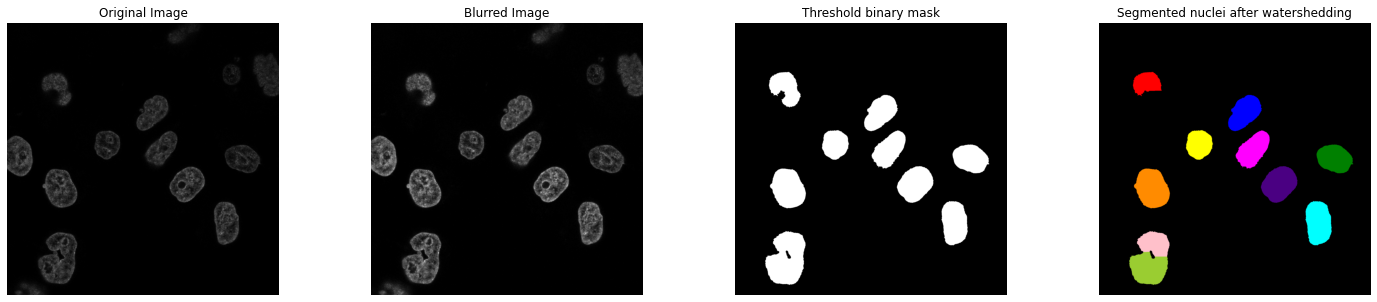

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #3.tif


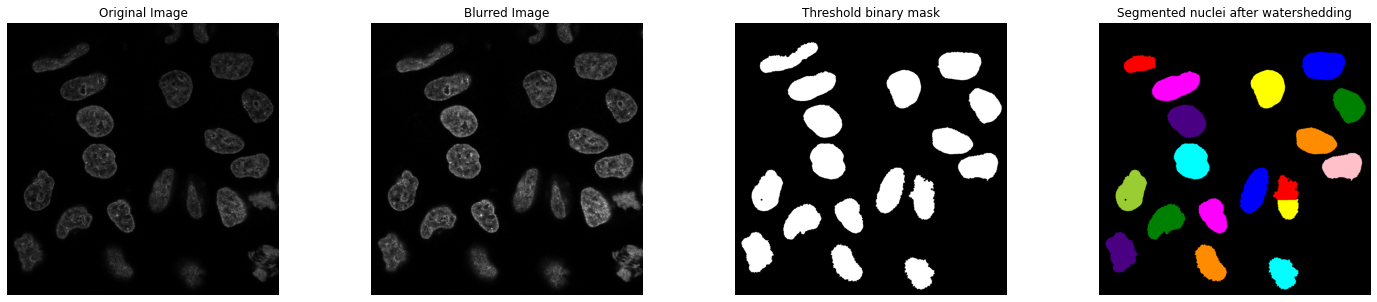

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #2.tif


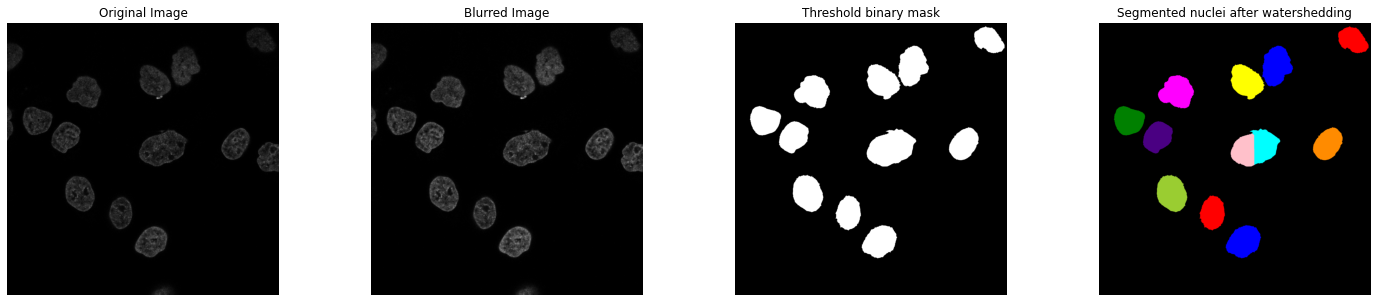

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos2-5 #1.tif


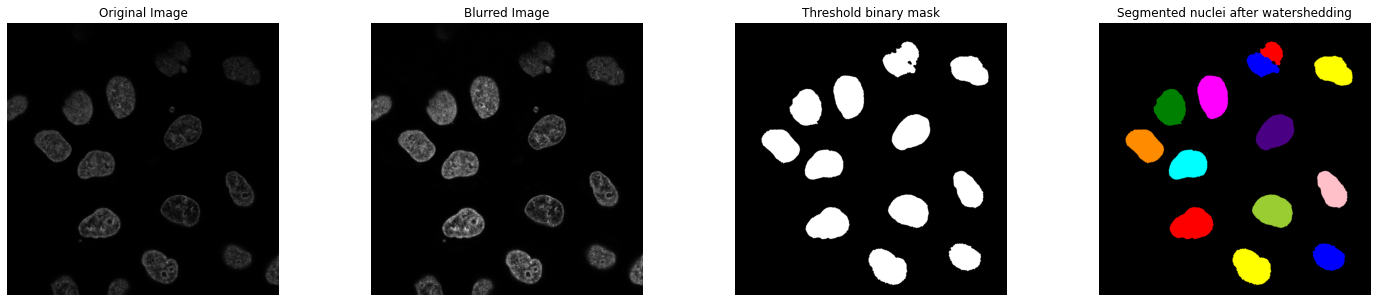

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos21-24 #4.tif


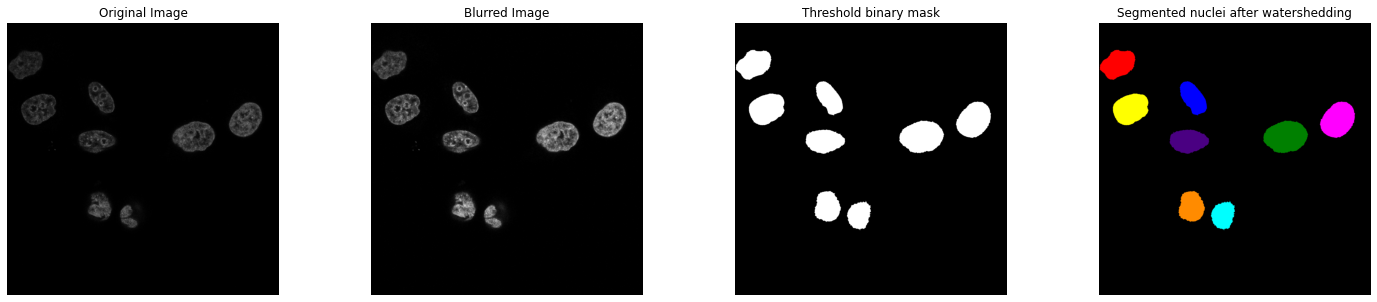

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos21-24 #3.tif


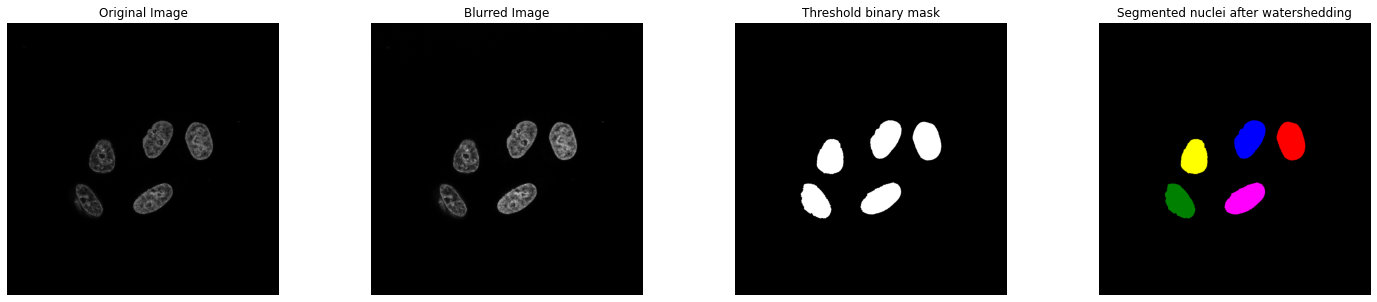

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos21-24 #2.tif


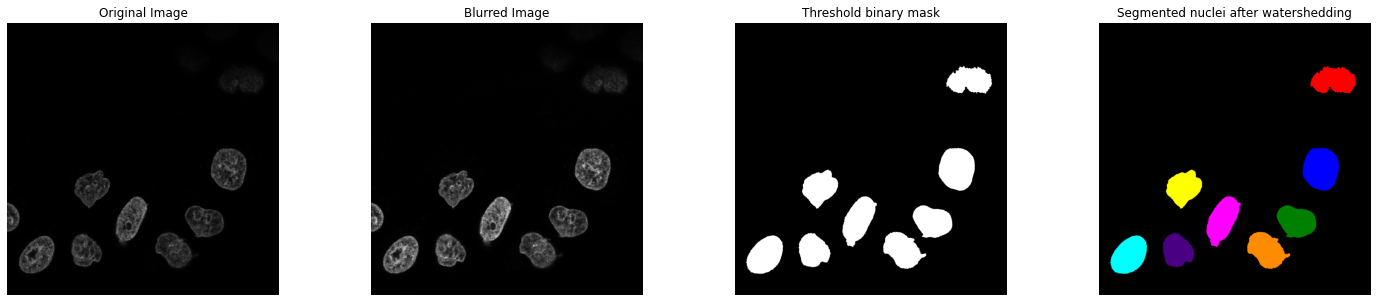

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #1.tif


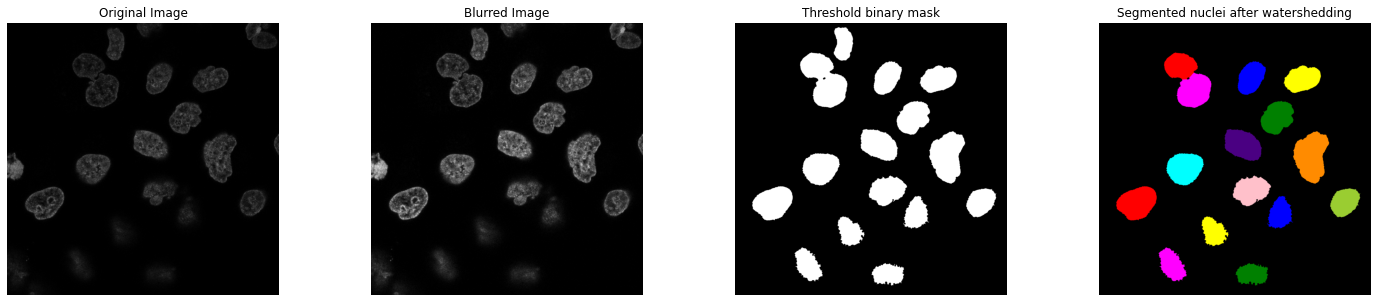

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos2-5 #4.tif


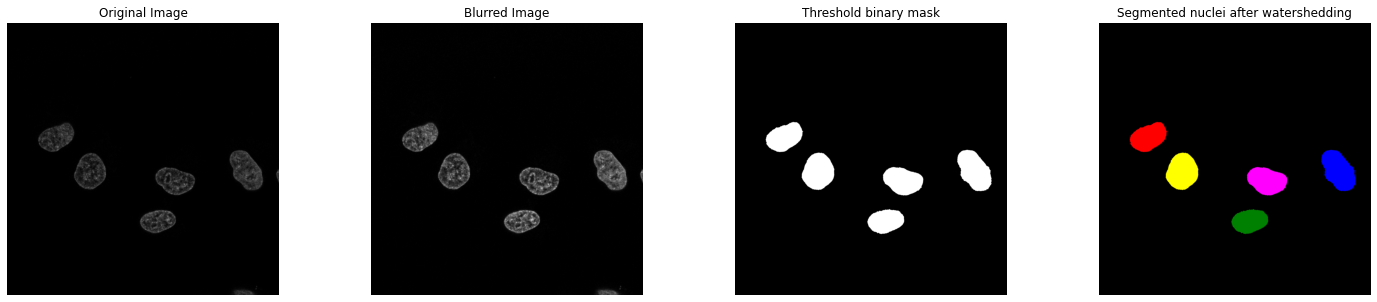

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos2-5 #3.tif


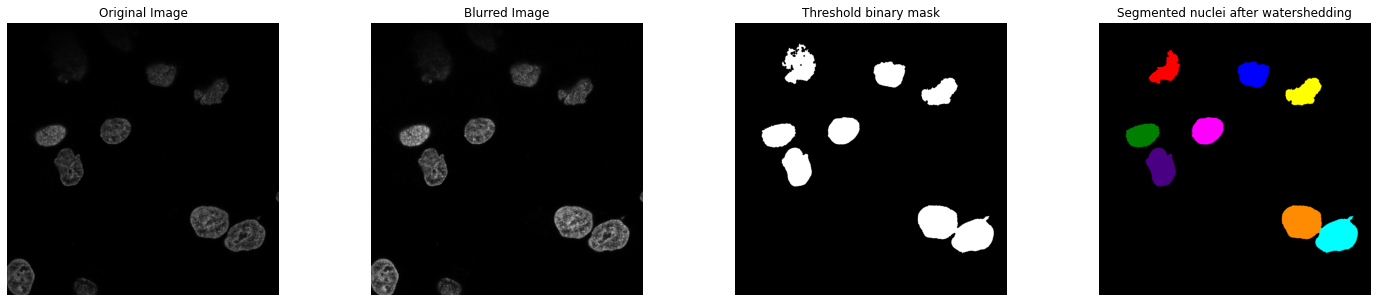

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos6-13 #4.tif


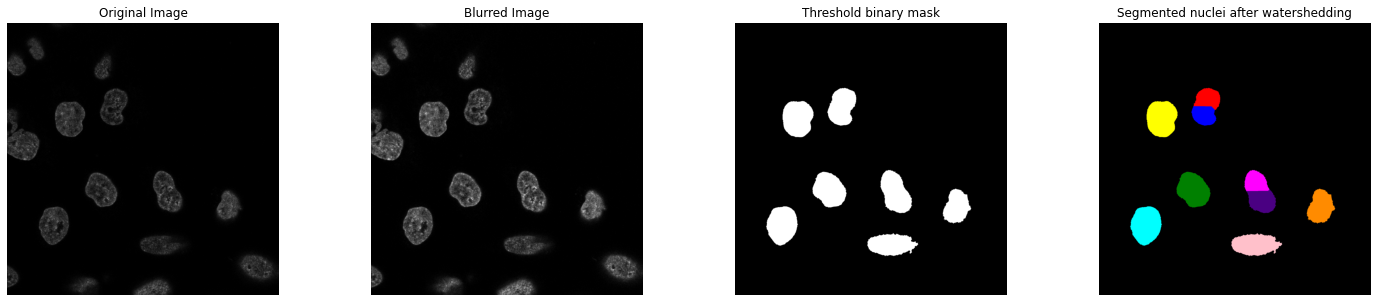

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos21-24 #1.tif


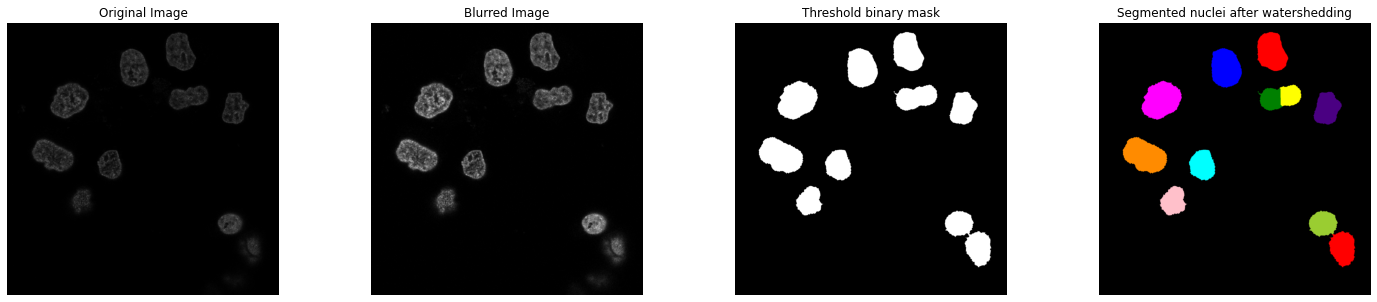

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos2-5 #2.tif


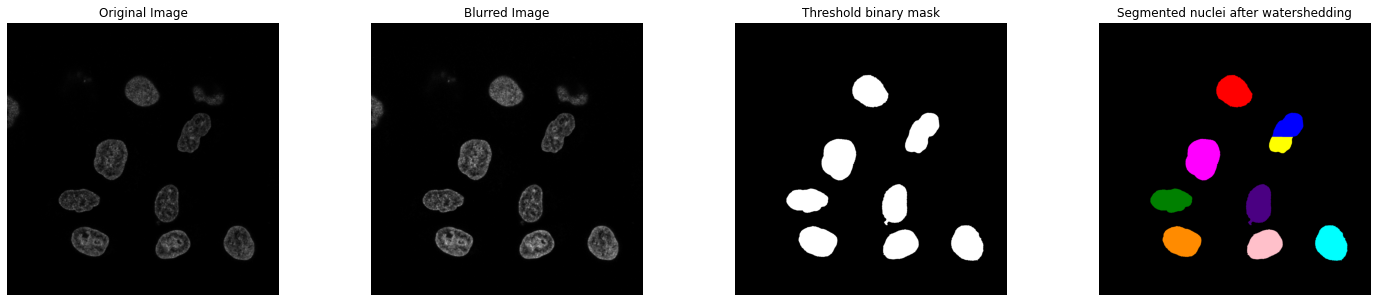

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1.tif


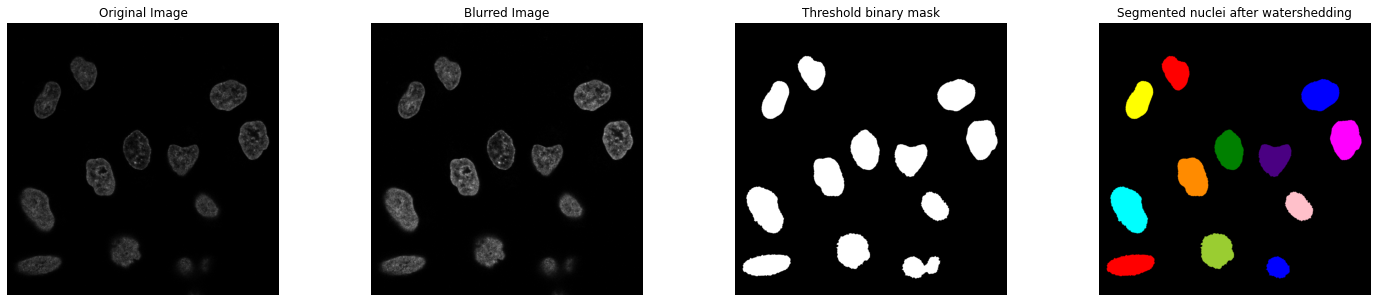

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos17-20 #3.tif


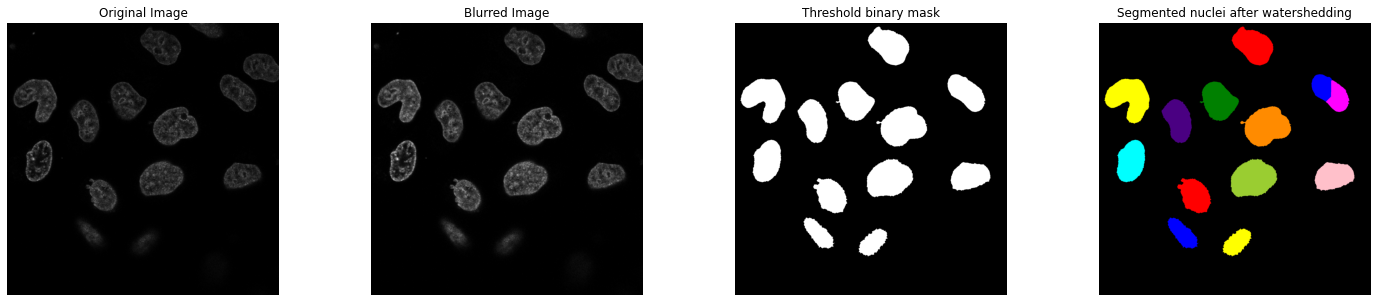

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos17-20 #4.tif


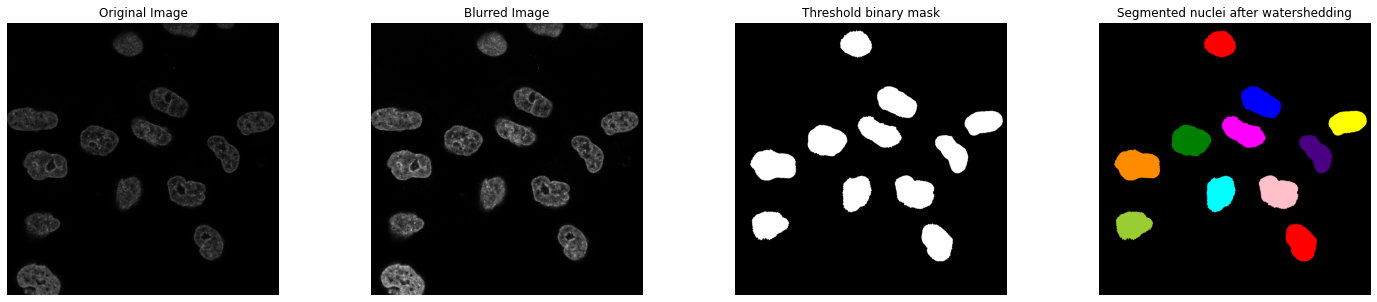

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos17-20 #1.tif


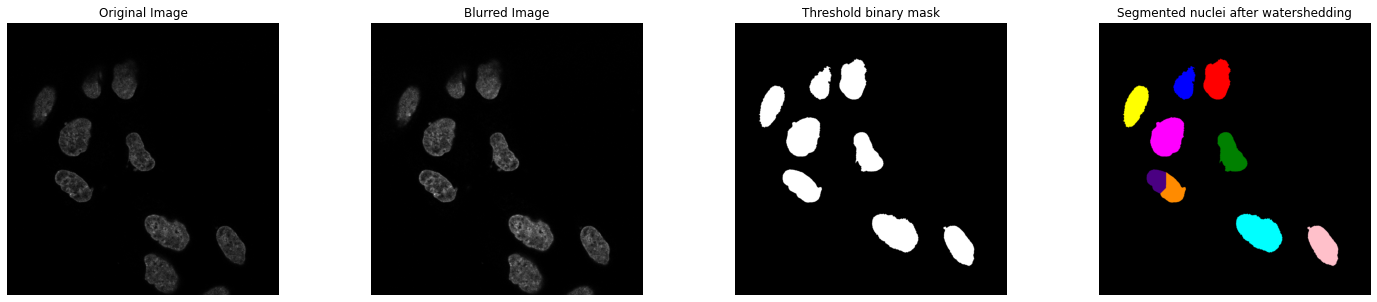

2108_well2_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos17-20 #2.tif


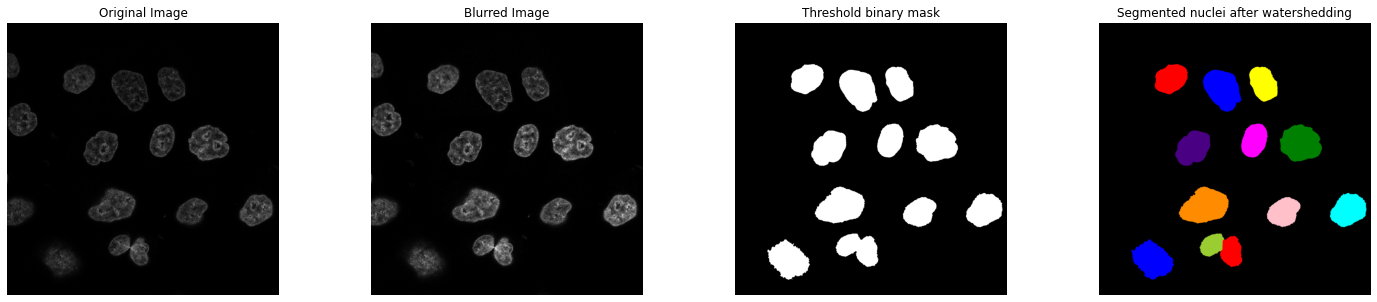

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos41-44 #2.tif


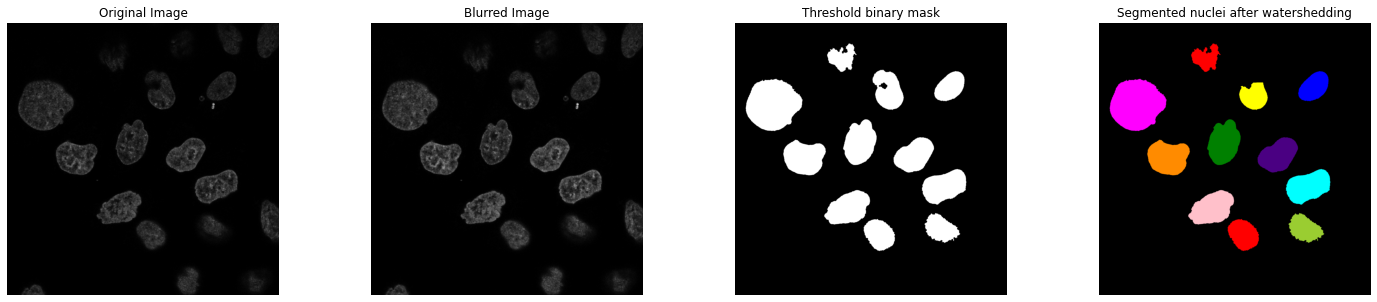

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #08.tif


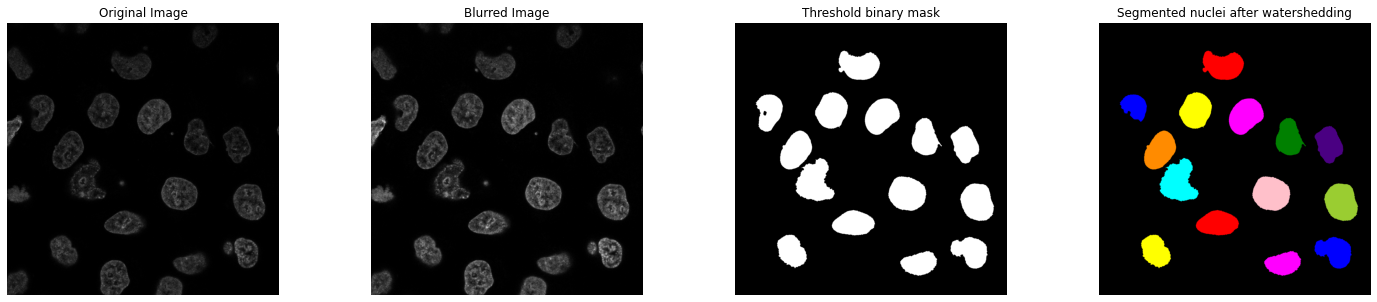

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #07.tif


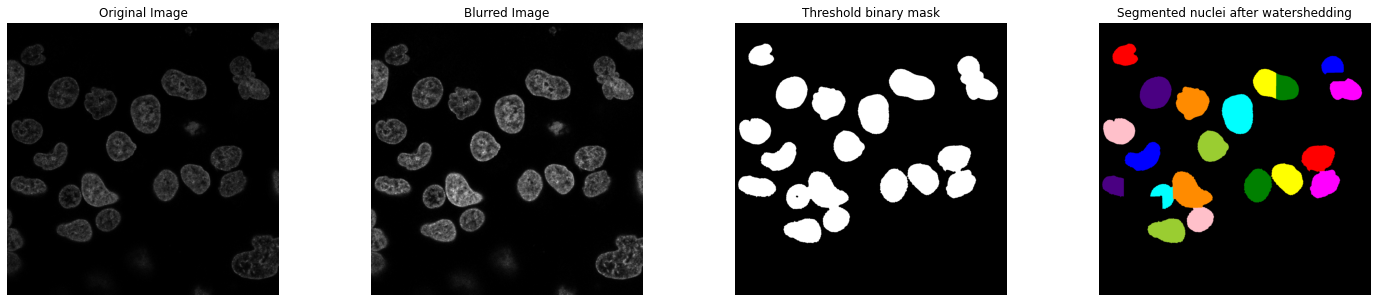

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #04.tif


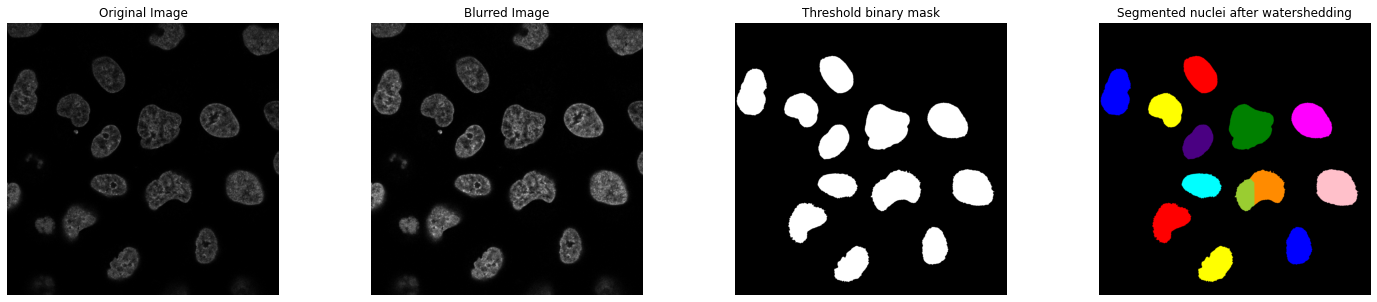

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #06.tif


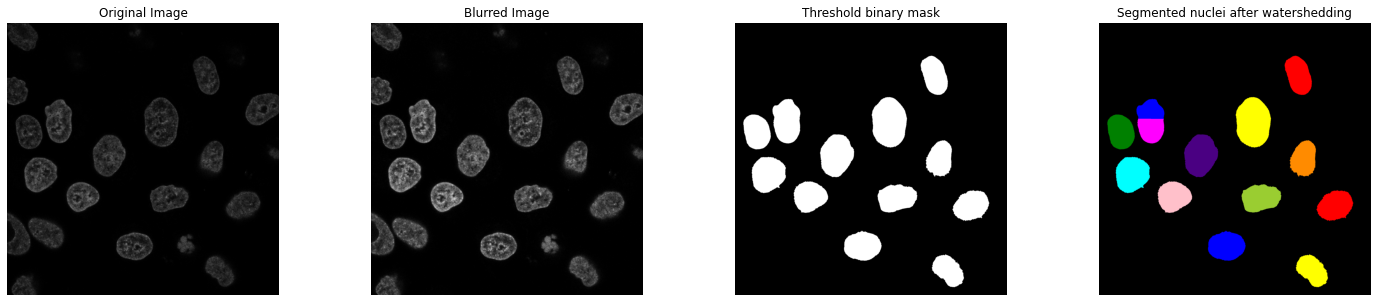

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #05.tif


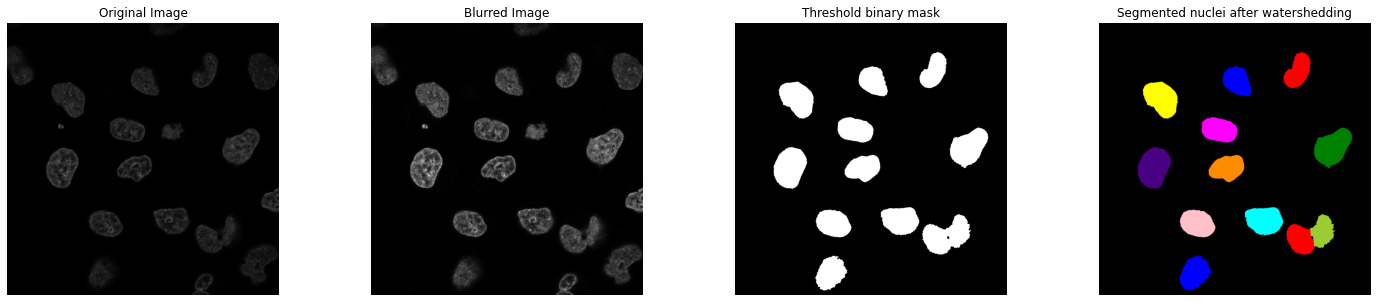

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #10.tif


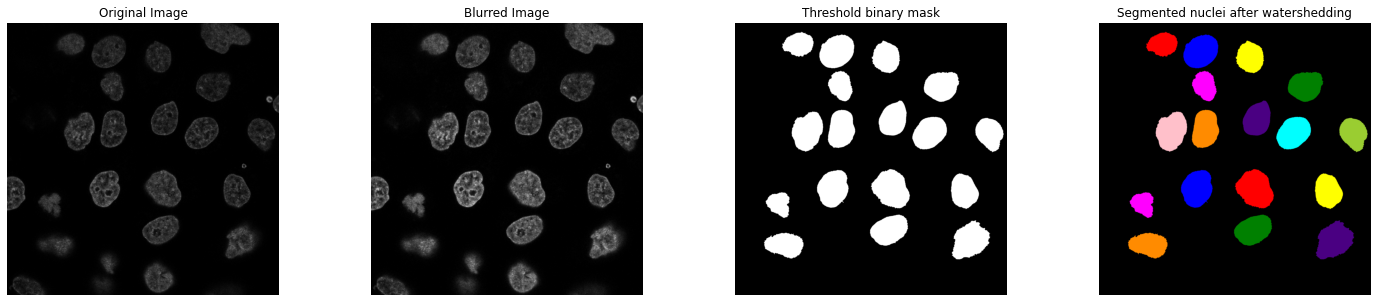

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #02.tif


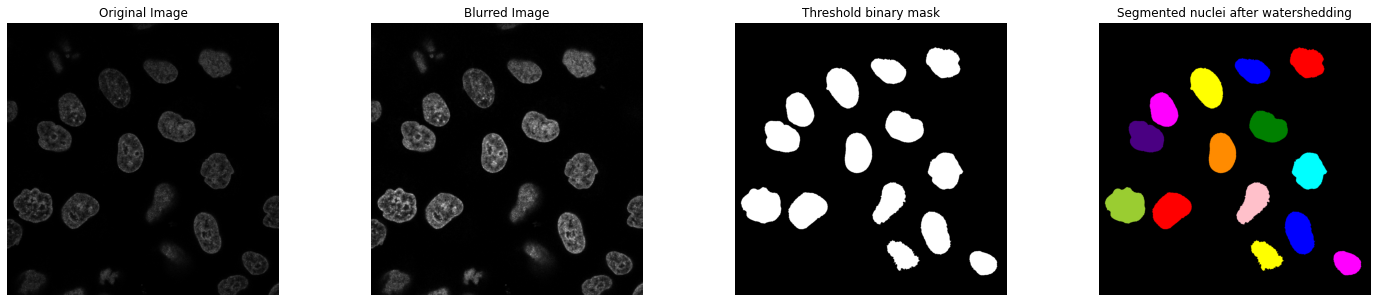

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #01.tif


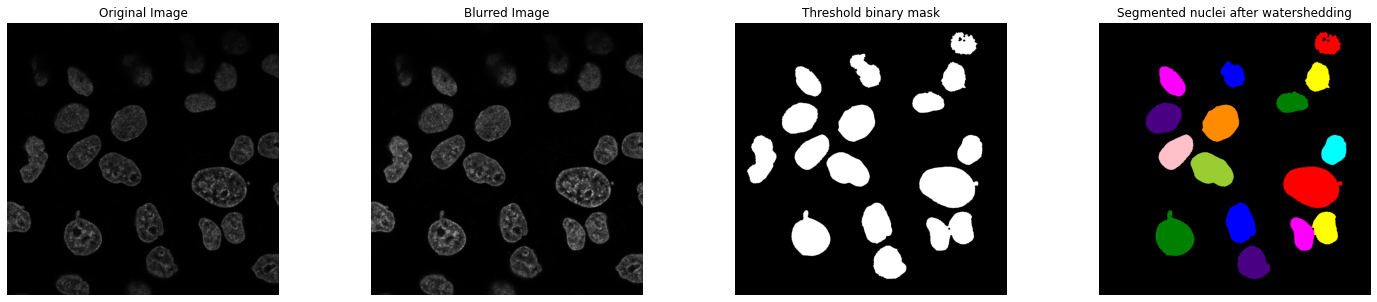

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #02.tif


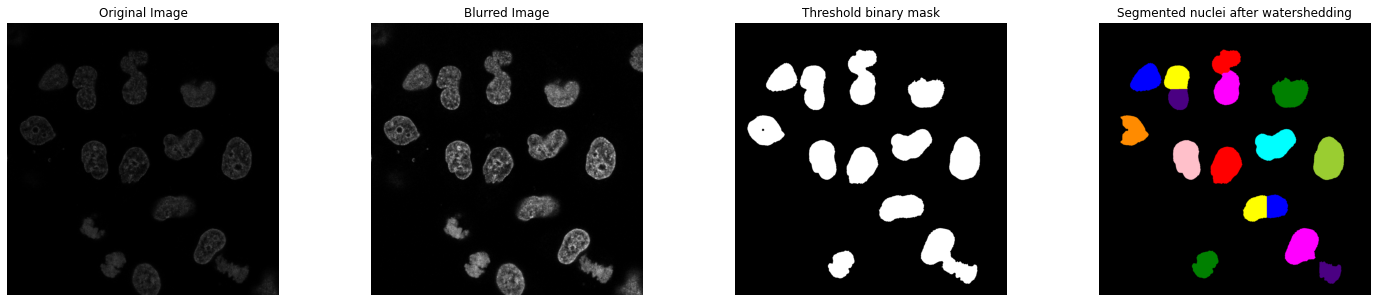

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos41-44 #4.tif


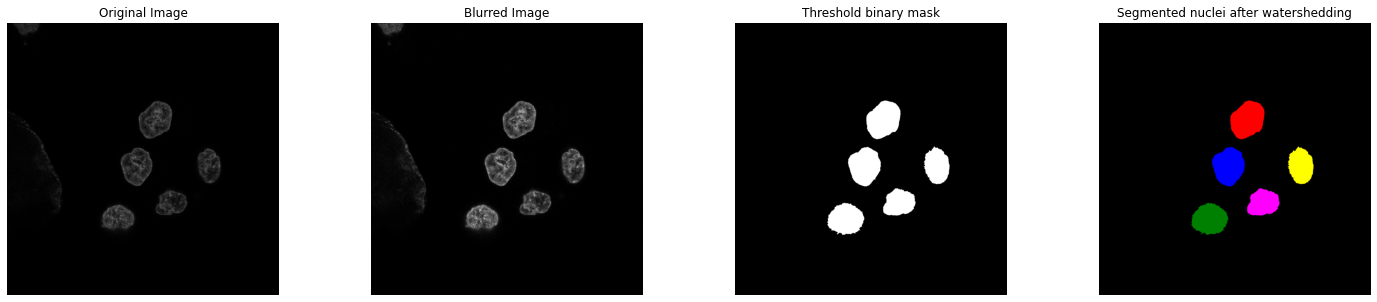

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #03.tif


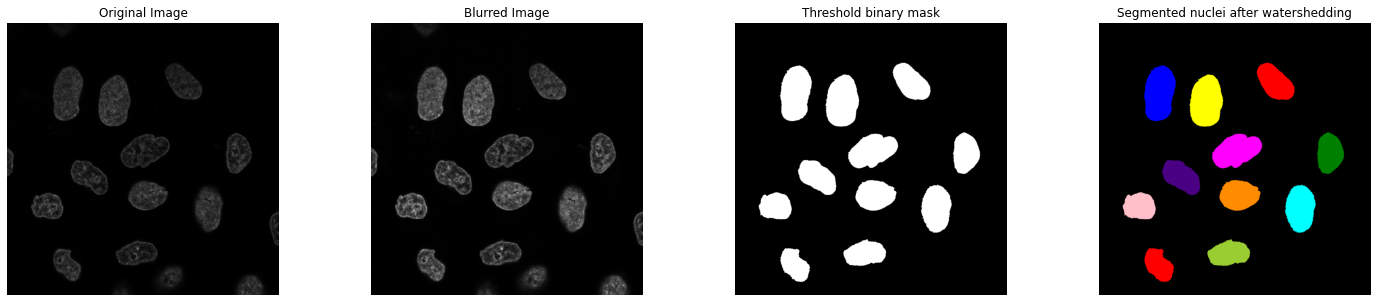

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #04.tif


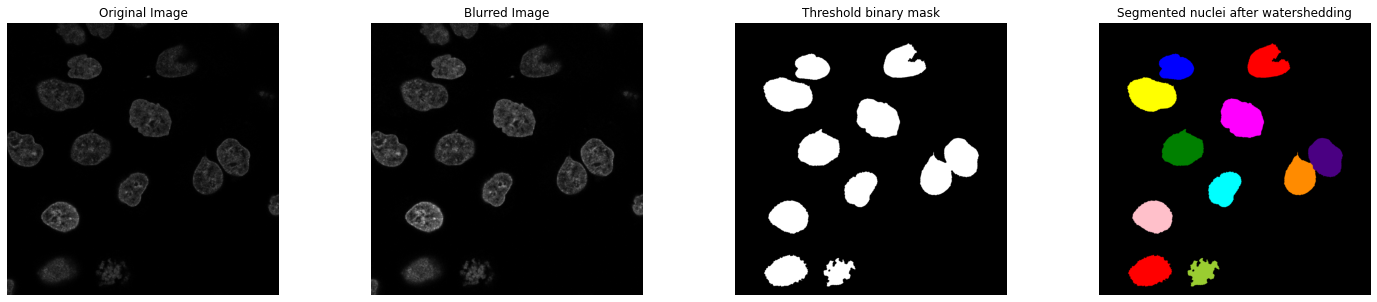

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #11.tif


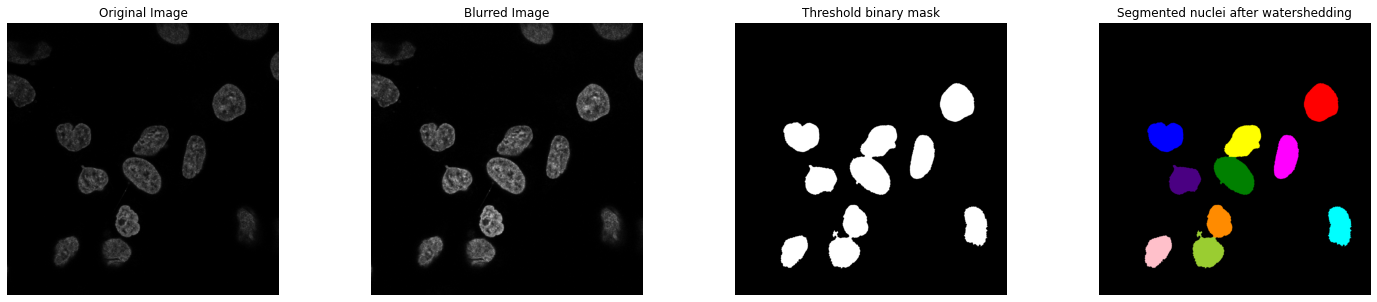

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #10.tif


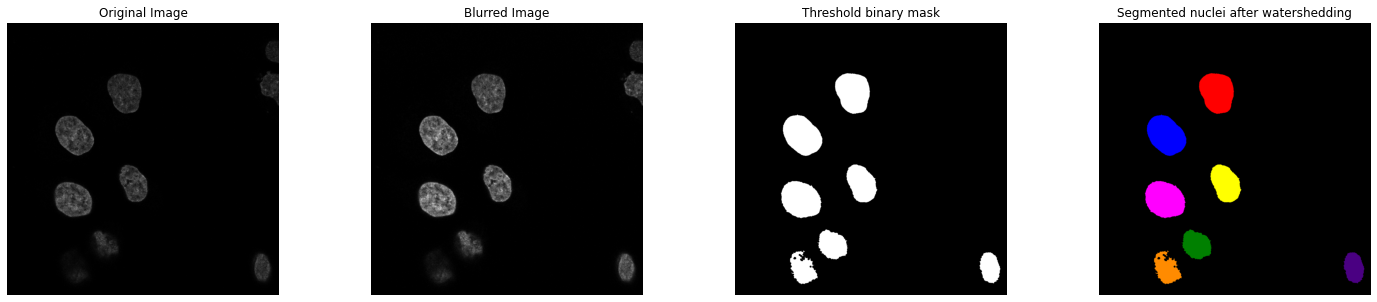

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #09.tif


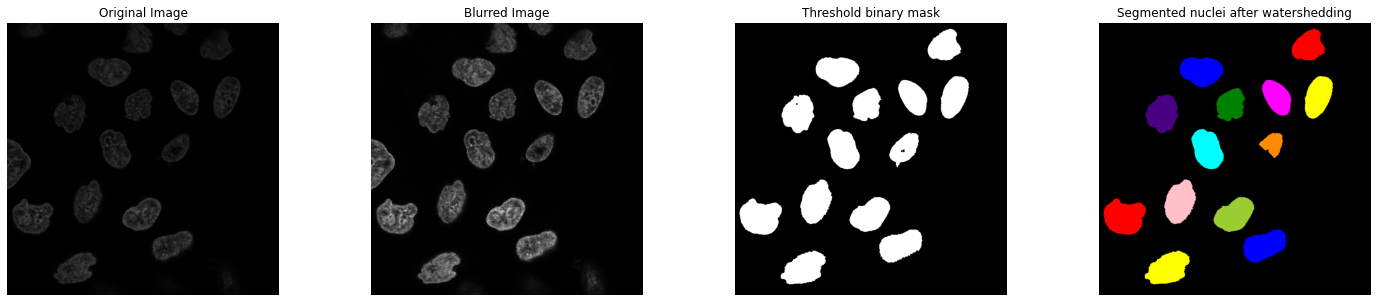

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #08.tif


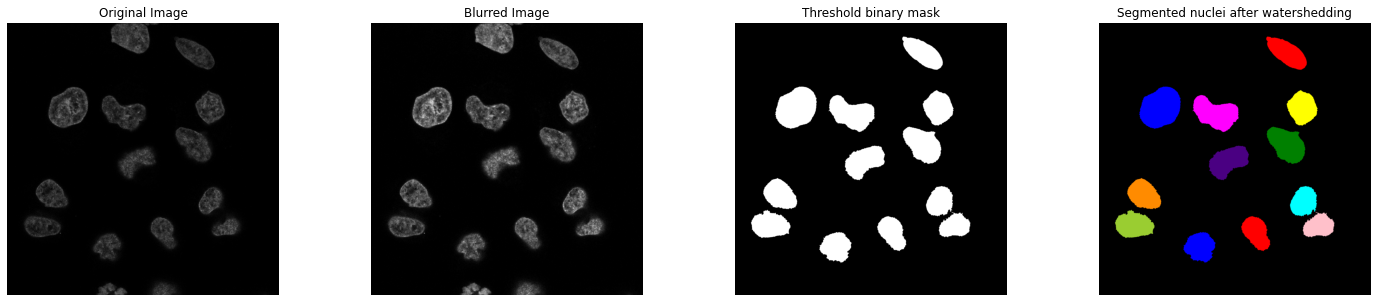

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #01.tif


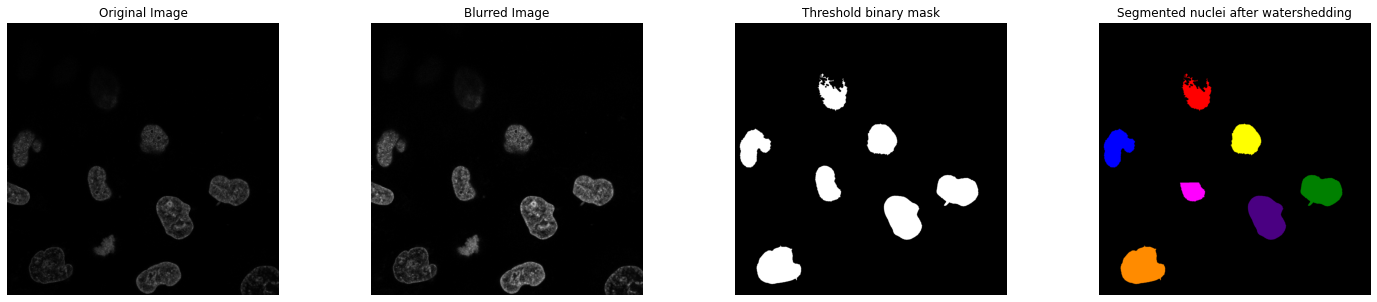

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #07.tif


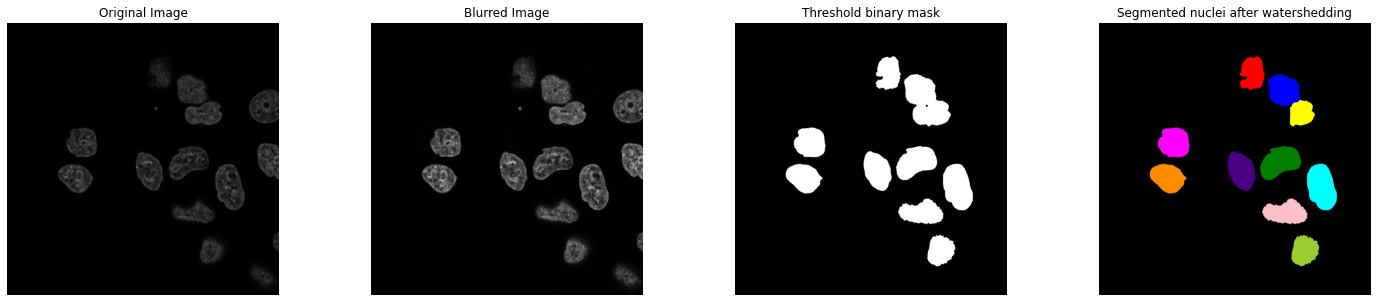

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #03.tif


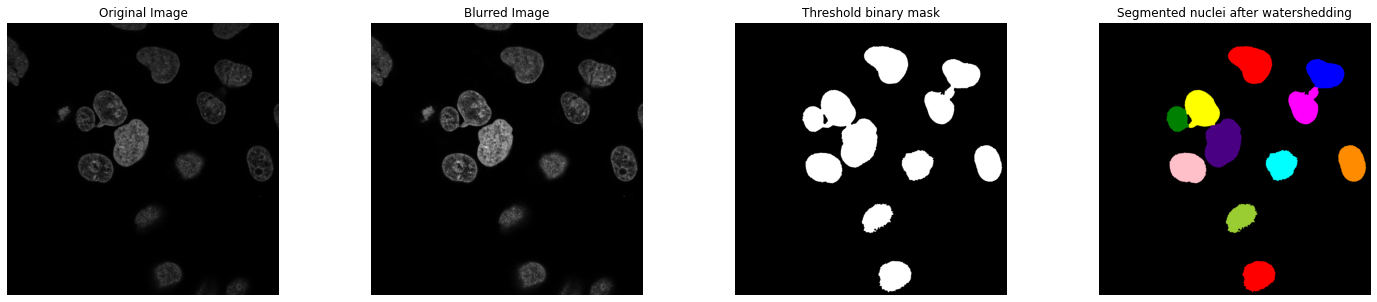

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #05.tif


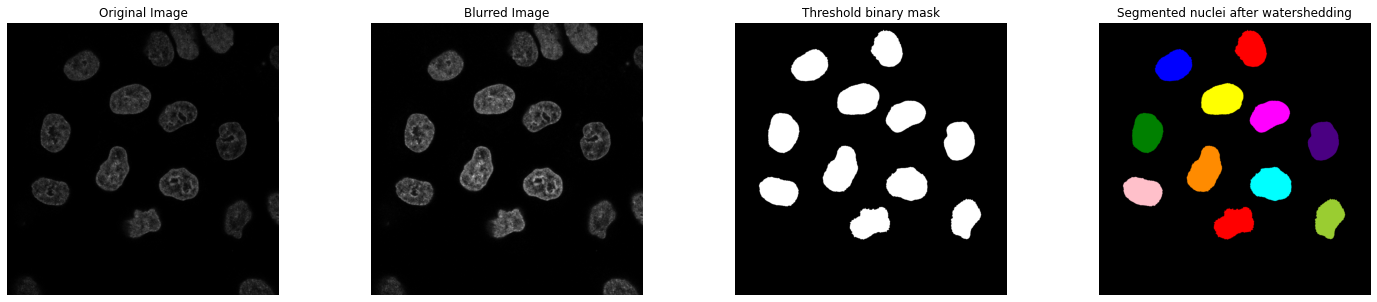

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #04.tif


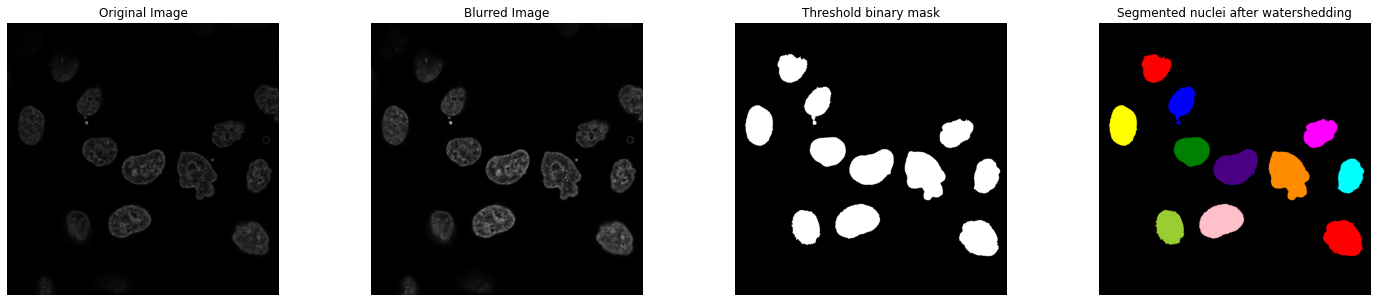

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #02.tif


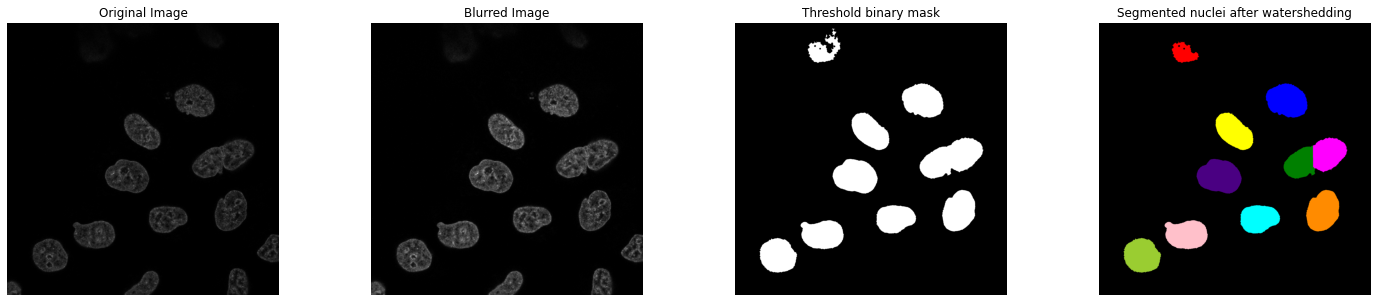

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #06.tif


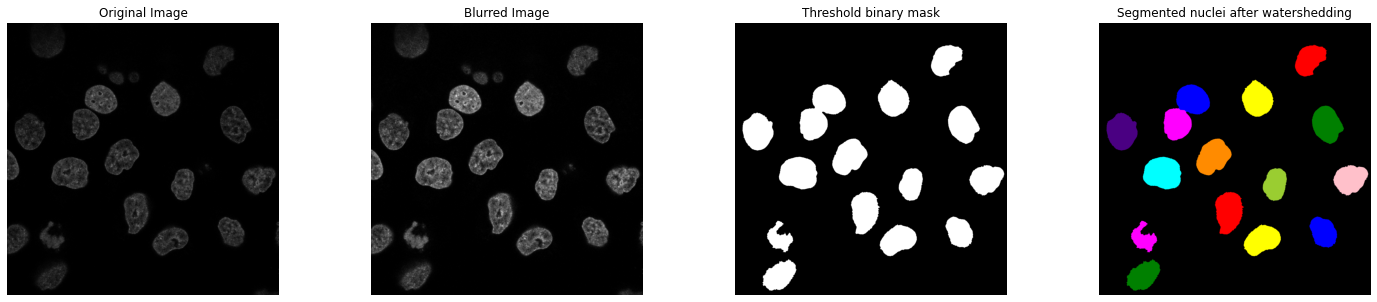

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #19.tif


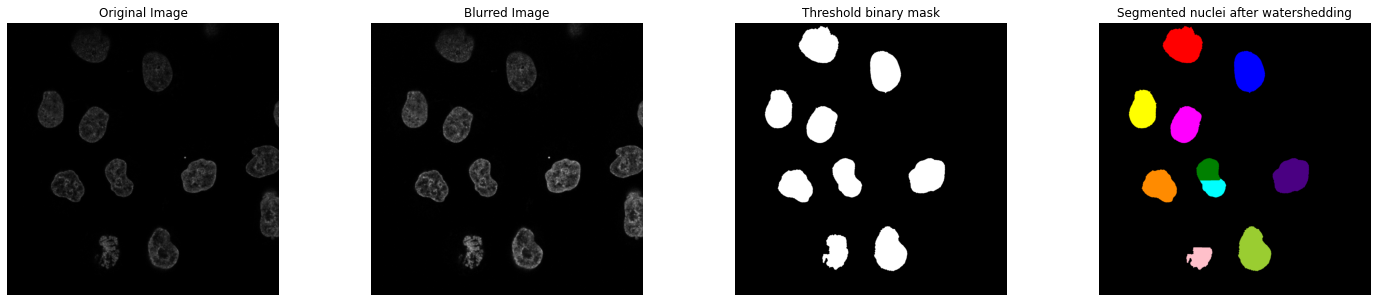

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #18.tif


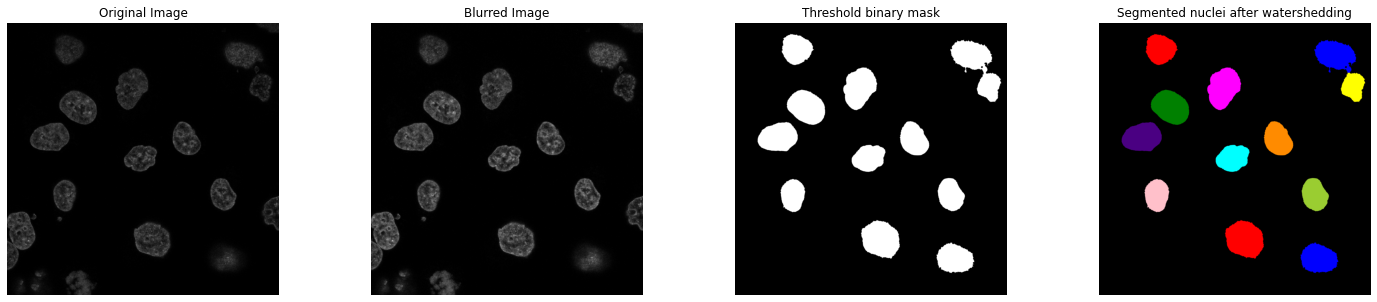

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos30-40 #01.tif


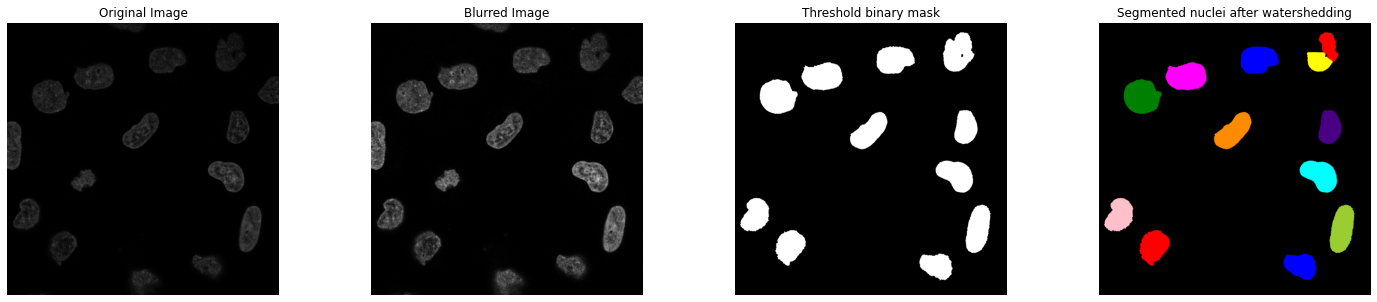

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #16.tif


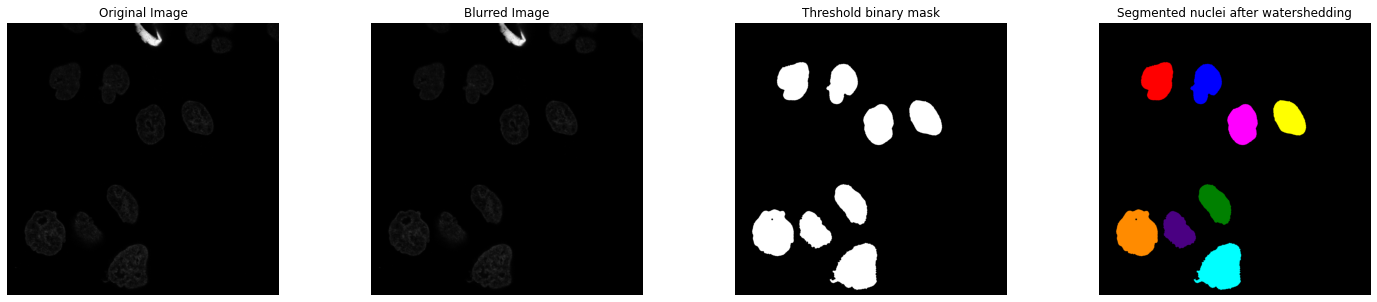

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #15.tif


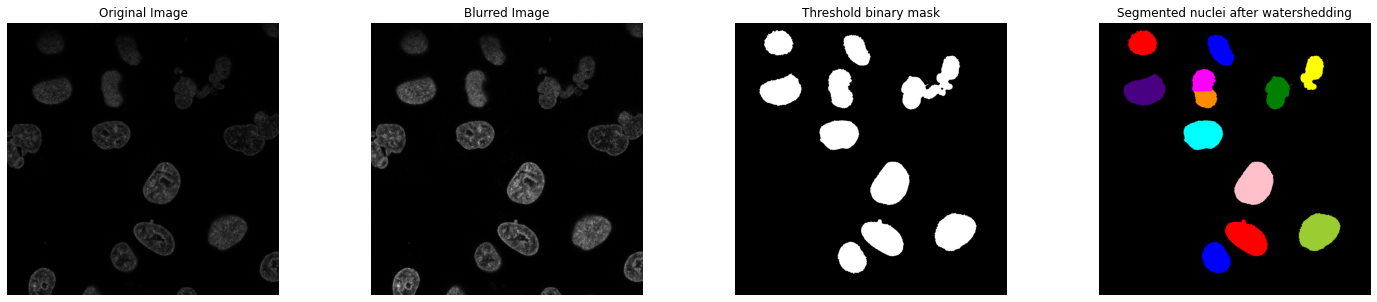

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #17.tif


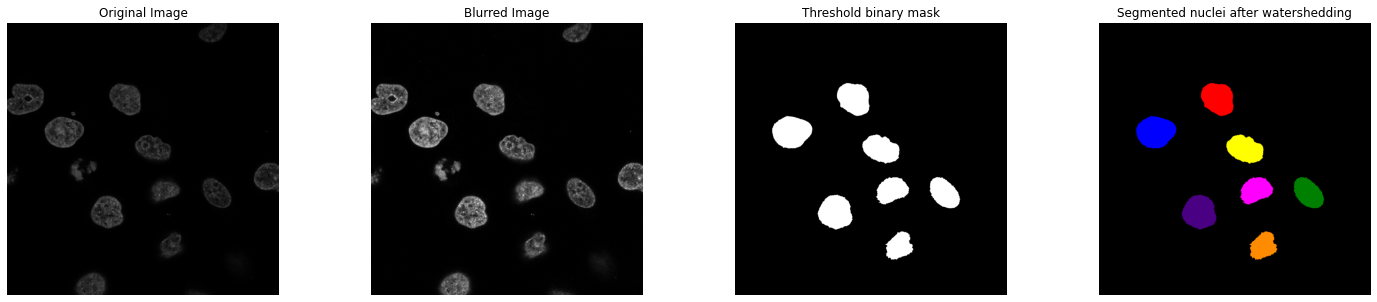

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #13.tif


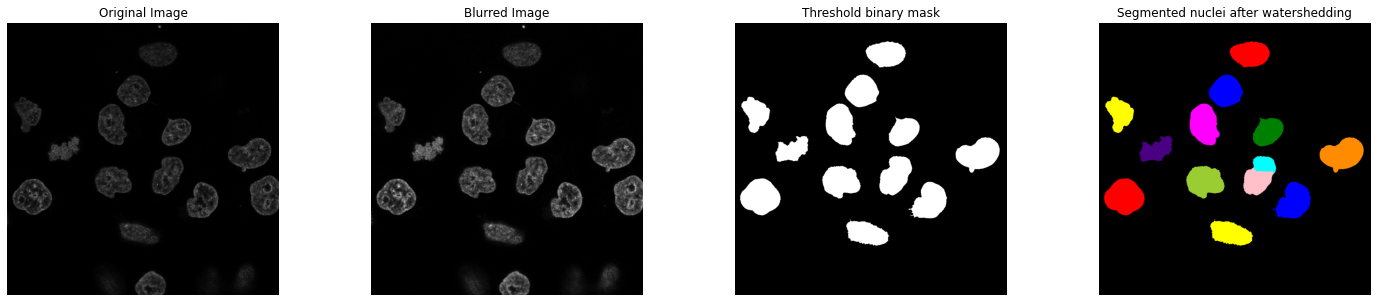

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #12.tif


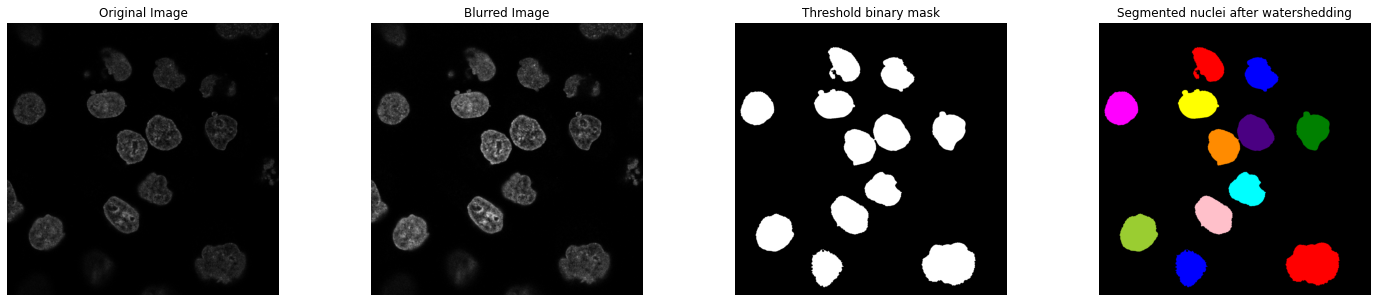

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #11.tif


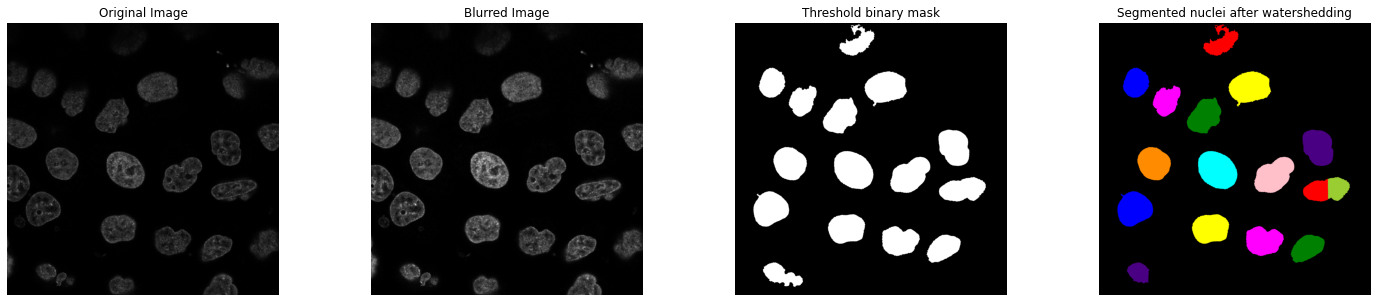

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #14.tif


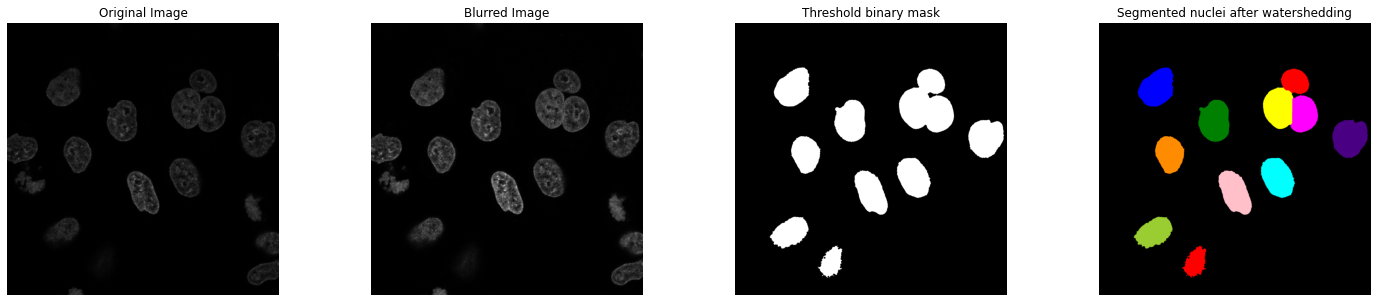

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #09.tif


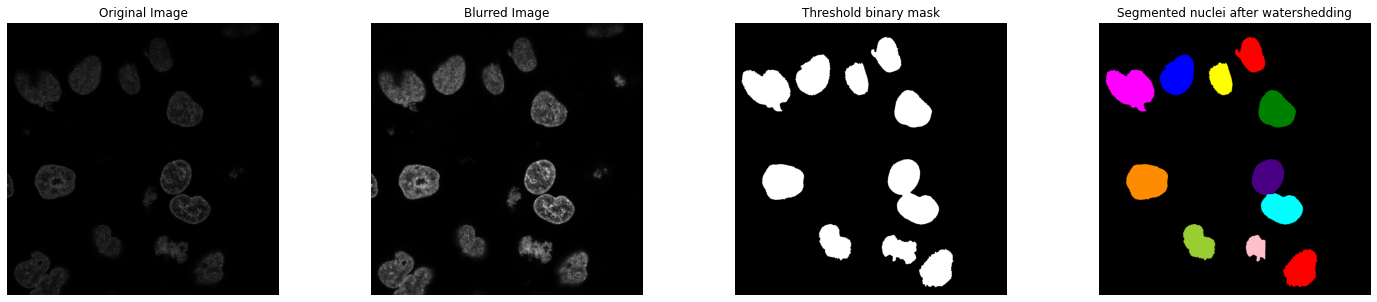

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #08.tif


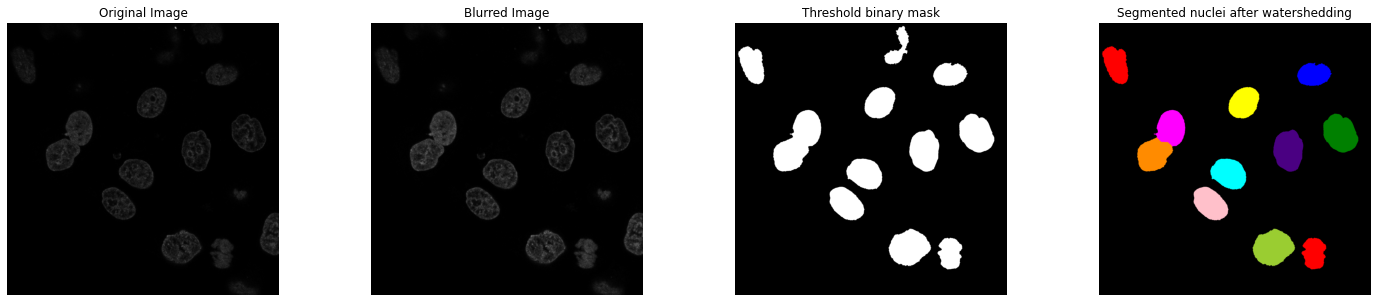

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #07.tif


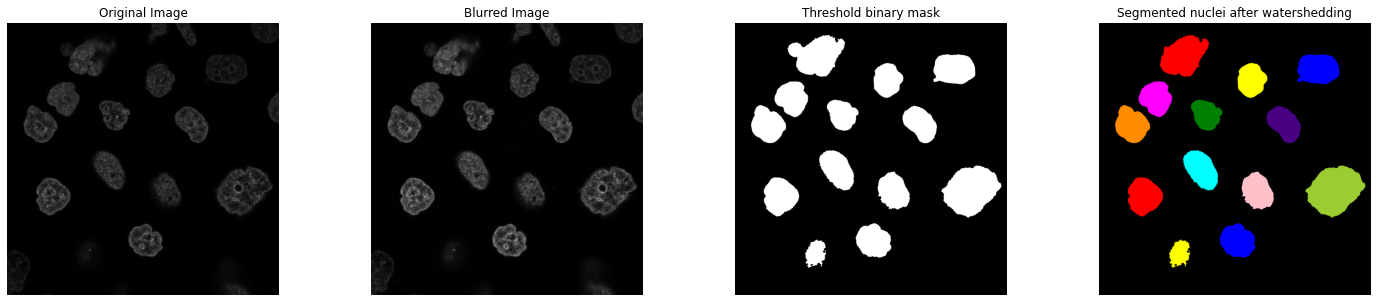

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #06.tif


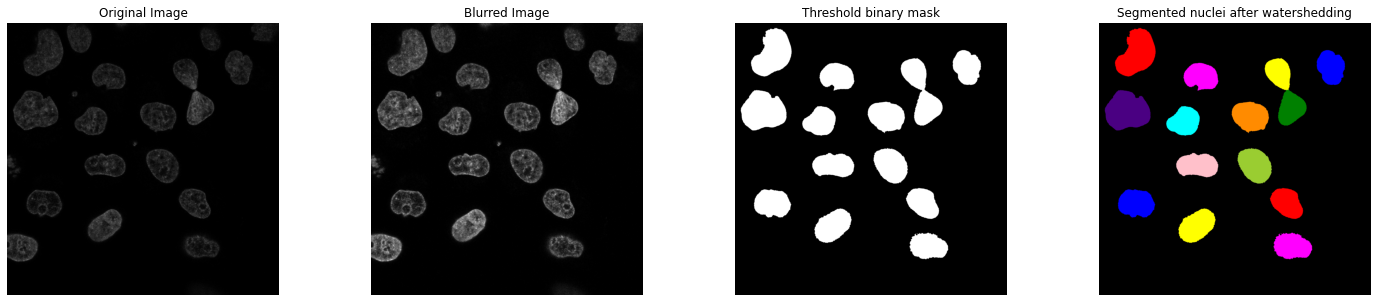

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #05.tif


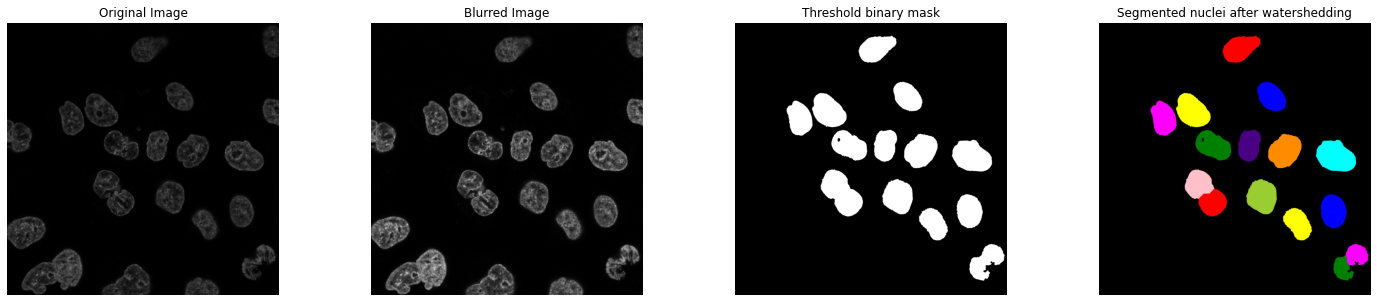

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos11-29 #10.tif


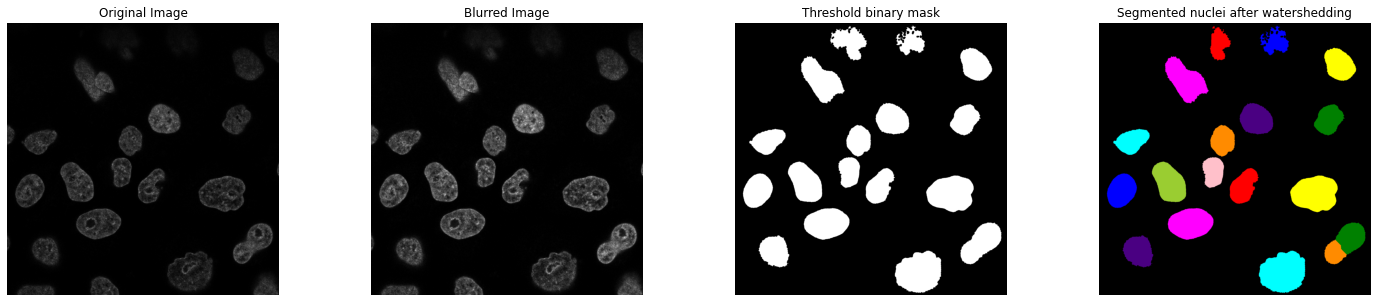

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos1-10 #03.tif


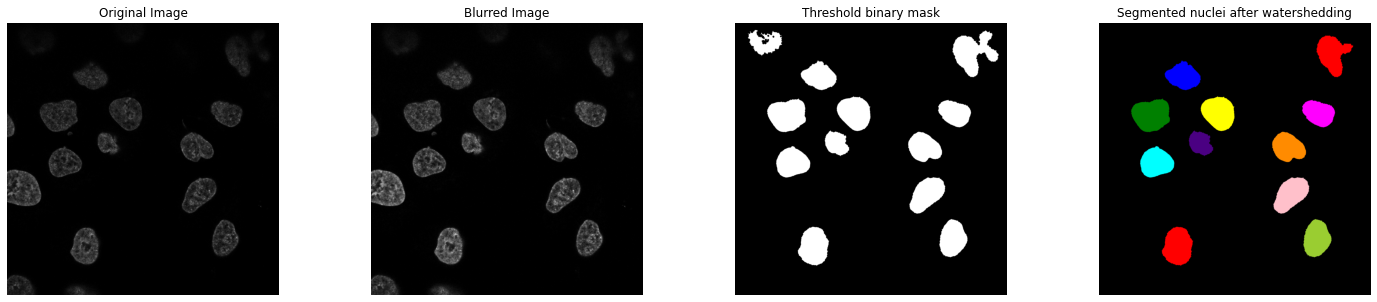

2108_well1_plus_dtag_plus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos41-44 #3.tif


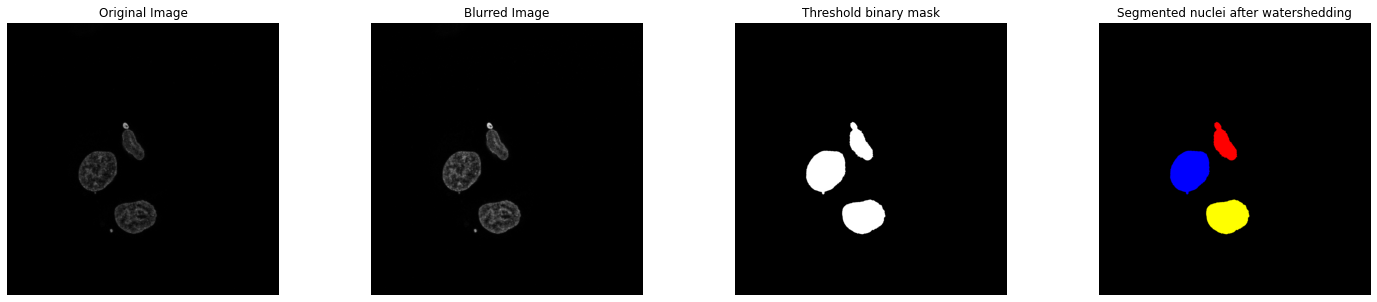

In [13]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt2_220830/2108_plus_aux_plus_dtag/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [14]:
result

nuclear_area_microns  mean_hoechst  mean_scc1  mean_smc4  mean_wapl  \
0             272.339075     16.309706  45.602437   6.209355   7.821596   
1             280.319744     24.044784  53.180149   5.826870   8.268740   
2             200.288881     20.509638  51.324288   5.584902   8.129486   
3             275.970728     24.885951  43.551185   5.065112   7.458274   
4             141.036650      8.803469  19.741161   4.353820   6.646427   
..                   ...           ...        ...        ...        ...   
8             206.152331     15.408825  38.127978   4.667150   7.115074   
9             190.360371     15.158641  38.011044   4.525411   6.826442   
10            218.521869     19.146427  42.461347   4.973829   6.943121   
1             314.494143     19.910280  40.079550   6.763805   7.876810   
2             277.106554     20.137384  41.315703   5.943407   7.827218   

    total_hoechst  total_nuclear_scc1  total_nuclear_smc4  total_nuclear_wapl  \
0     4441.770215        12419.325402         1691.049904         2130.126173   
1     6740.227722        14907.445842         1633.386833         2317.891083   
2     4107.852459        10279.684200         1118.593845         1628.245728   
3     6867.793879        12018.852256         1397.822599         2058.265282   
4     1241.611719         2784.227163          614.048196          937.389822   
..            ...                 ...                 ...                 ...   
8     3176.565208         7860.171605          962.143844         1466.789127   
9     2885.604572         7235.796364          861.458890         1299.484022   
10    4183.912915         9278.732984         1086.890365         1517.223766   
1     6261.666572        12604.783789         2127.177012         2477.210538   
2     5580.201153        11448.852170         1646.956959         2168.973398   

    std_hoechst   std_scc1  coeff_variance_hoechst  coeff_variance_smc4  \
0      8.838404  33.541501                0.541911             0.735520   
1     12.253812  37.534904                0.509625             0.705807   
2     11.184566  35.449096                0.545332             0.690689   
3     12.867674  32.164389                0.517066             0.738542   
4      7.234920  15.695121                0.821826             0.795045   
..          ...        ...                     ...                  ...   
8     10.055376  29.036382                0.652573             0.761551   
9      9.862044  28.810105                0.650589             0.757940   
10    11.195424  31.357287                0.584727             0.738490   
1     11.905805  33.913800                0.597973             0.846162   
2     11.759643  33.169499                0.583971             0.802830   

                  condition  
0   2108_plus_aux_plus_dtag  
1   2108_plus_aux_plus_dtag  
2   2108_plus_aux_plus_dtag  
3   2108_plus_aux_plus_dtag  
4   2108_plus_aux_plus_dtag  
..                      ...  
8   2108_plus_aux_plus_dtag  
9   2108_plus_aux_plus_dtag  
10  2108_plus_aux_plus_dtag  
1   2108_plus_aux_plus_dtag  
2   2108_plus_aux_plus_dtag  

[717 rows x 14 columns]

In [30]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [31]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt2_220830/2108_untreated/2108_well1_minus_aux_stain_hoechst_scc1_smc4-halo-tmr_wapl-ha_pos21-37 #14.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

shape: (1912, 1912, 4)
dtype: uint8
range: (0, 255)


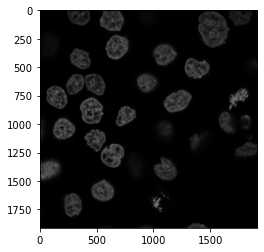

In [15]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
